In [62]:
import calendar
import holiday
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler


from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


from datetime import datetime
pd.set_option('display.max_columns', None)

### Task 1: Outliers Detection

We started with some exploratory analysis to see if there are any year over year trend, seasonality trend or cyclic trend showing in the data set. We took a look from two aspects: 
1. number of trips
2. duration of each individual trip.

#### Number of Trips

In [201]:
df_stations = pd.read_csv('citibike-stations.csv')
df_trip = pd.read_csv('citibike-trips-sample.csv')

#### date format
df_trip['starttime'] = pd.to_datetime(df_trip['starttime'])
df_trip['stoptime'] = pd.to_datetime(df_trip['stoptime'])
df_trip['start_year'] = df_trip['starttime'].dt.year
df_trip['start_month'] = df_trip['starttime'].dt.month
df_trip['start_week'] = df_trip['starttime'].dt.week
df_trip['start_day'] = df_trip['starttime'].dt.day
df_trip['start_dow'] = df_trip['starttime'].dt.dayofweek
df_trip['start_doy'] = df_trip['starttime'].dt.dayofyear

df_trip['starttime_ft'] = df_trip['starttime'].dt.normalize()

#### add holiday features
cal = calendar()
holidays = cal.holidays(start=df_trip['starttime'].min(), end=df_trip['starttime'].max())
df_trip['holiday'] = df_trip['starttime'].dt.normalize().isin(holidays)
df_trip['holiday'] = df_trip['holiday'].astype(int)

print(df_trip.shape)
df_trip.head(3)

/var/folders/g7/gjfwvdlx1kj9kyvp5fqd0t8m0000gn/T/ipykernel_47112/4081539337.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_trip['start_week'] = df_trip['starttime'].dt.week


(315785, 24)


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_year,start_month,start_week,start_day,start_dow,start_doy,starttime_ft,holiday
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN,2016,3,10,9,2,69,2016-03-09,0
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN,2015,7,28,9,3,190,2015-07-09,0
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN,2016,1,2,11,0,11,2016-01-11,0


In [4]:
df_trip.describe()

,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,customer_plan,start_year,start_month,start_week,start_day,start_dow,start_doy
count,3.157850e+05,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,276894.000000,0.0,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000,315785.000000
mean,9.384988e+02,638.426236,40.735735,-73.989392,631.766471,40.735366,-73.989326,19074.896870,1976.528812,NaN,2014.693956,7.100112,29.201777,15.832034,2.844198,200.679336
std,6.534950e+03,772.408824,0.020822,0.014088,762.145089,0.075412,0.132420,2888.180823,11.449689,NaN,1.036277,2.804010,12.322268,8.669115,1.943684,85.339921
min,6.000000e+01,72.000000,40.646678,-74.017134,72.000000,0.000000,-74.017134,14529.000000,1885.000000,NaN,2013.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,3.910000e+02,312.000000,40.721101,-73.999318,312.000000,40.720874,-73.999744,16687.000000,1969.000000,NaN,2014.000000,5.000000,20.000000,8.000000,1.000000,140.000000
50%,6.310000e+02,428.000000,40.736529,-73.990093,427.000000,40.736502,-73.990214,18779.000000,1979.000000,NaN,2015.000000,7.000000,30.000000,16.000000,3.000000,207.000000
75%,1.051000e+03,501.000000,40.750977,-73.981281,499.000000,40.750664,-73.981346,21090.000000,1986.000000,NaN,2016.000000,9.000000,39.000000,23.000000,4.000000,265.000000
max,1.733173e+06,3425.000000,40.804213,-73.929891,3427.000000,40.804213,0.000000,26884.000000,2000.000000,NaN,2016.000000,12.000000,53.000000,31.000000,6.000000,365.000000


In [5]:
df_trip.stoptime.max()

Timestamp('2016-08-30 23:50:00')

In [6]:
tmp = df_trip.groupby(['start_year','start_month']).agg({'tripduration':'count'}).reset_index()
tmp.pivot(index='start_year',columns='start_month',values = 'tripduration')

start_month,1,2,3,4,5,6,7,8,9,10,11,12
start_year,,,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,8296.0,10151.0,10476.0,10495.0,6776.0,4517.0
2014,2963.0,2212.0,4357.0,6614.0,8577.0,9337.0,9582.0,9805.0,9527.0,8308.0,5235.0,4016.0
2015,2870.0,1906.0,3408.0,6530.0,9542.0,9286.0,10926.0,11776.0,12982.0,12130.0,9751.0,8123.0
2016,5031.0,5480.0,9029.0,10226.0,12157.0,14556.0,13856.0,14976.0,NaN,NaN,NaN,NaN


we could find 2013 and 2016 doesn't have the full year data. So it doesn't make sense to compare the full year volume. Instead we will transform to daily trip volume and then compare the mean value across each year.

Text(0.5, 0, 'average daily trips')

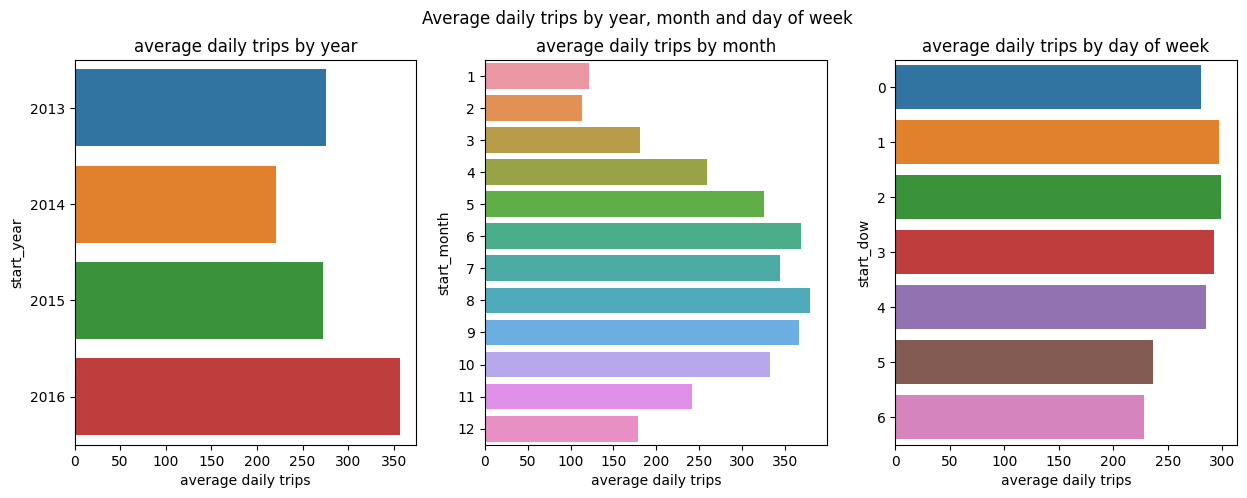

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Average daily trips by year, month and day of week')

daily = df_trip.groupby(['start_year','starttime_ft','start_month','start_dow']).agg({'tripduration':'count'}).reset_index()

# by year
tmp = daily.groupby('start_year').agg({'tripduration':'mean'}).reset_index()
sns.barplot(ax=axes[0], x='tripduration', y='start_year',data=tmp,orient='h')
axes[0].set_title('average daily trips by year')
axes[0].set_xlabel('average daily trips')

# by month
tmp = daily.groupby('start_month').agg({'tripduration':'mean'}).reset_index()
sns.barplot(ax=axes[1], x='tripduration', y='start_month',data=tmp,orient='h')
axes[1].set_title('average daily trips by month')
axes[1].set_xlabel('average daily trips')

# by day of week
tmp = daily.groupby('start_dow').agg({'tripduration':'mean'}).reset_index()
sns.barplot(ax=axes[2], x='tripduration', y='start_dow',data=tmp,orient='h')
axes[2].set_title('average daily trips by day of week')
axes[2].set_xlabel('average daily trips')

#### Finding:

* we've noticed a year over year growth of daily trips from 2014 to 2016. However we've noticed a slightly drop from 2013 to 2014. The reason being 2013 only including month from July to Dec which have more high volume months.


* seasonality trend: users make more trips in the summer months than winter month


* cyclic trend: more trips happen on weekdays and less on weekend

<AxesSubplot:xlabel='starttime_ft', ylabel='tripduration'>

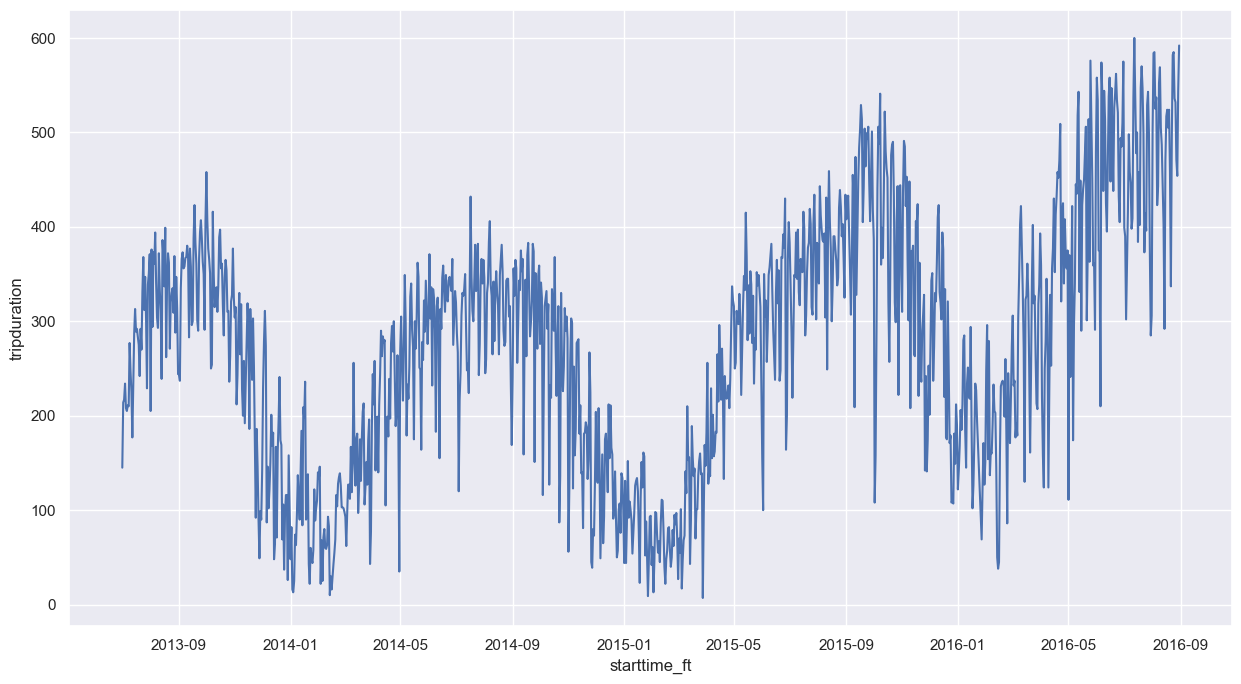

In [24]:
### we took a look of overall daily trip trend through time dimension
sns.set(rc={'figure.figsize':(15,8)})
sns.lineplot(x='starttime_ft',y='tripduration', data=daily)

In [154]:
#### Detection the outliers

# train test split
alldates = sorted(set(daily.starttime_ft.values))
daily = daily.sort_values(by='starttime_ft')
train, test = daily.loc[daily.starttime_ft.isin(alldates[:int(len(alldates)*0.95)])],daily.loc[~daily.starttime_ft.isin(alldates[:int(len(alldates)*0.8)])]
print(train.starttime_ft.min(),train.starttime_ft.max())
print(test.starttime_ft.min(),test.starttime_ft.max())
print(train.shape, test.shape)

# scale the daily trip
scaler = MinMaxScaler()
scaler = scaler.fit(daily[['tripduration']])

train['tripduration'] = scaler.transform(train[['tripduration']])
test['tripduration'] = scaler.transform(test[['tripduration']])


2013-07-01 00:00:00 2016-07-03 00:00:00
2016-01-09 00:00:00 2016-08-30 00:00:00
(1095, 5) (231, 5)


/var/folders/g7/gjfwvdlx1kj9kyvp5fqd0t8m0000gn/T/ipykernel_47112/2754962482.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['tripduration'] = scaler.transform(train[['tripduration']])
/var/folders/g7/gjfwvdlx1kj9kyvp5fqd0t8m0000gn/T/ipykernel_47112/2754962482.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['tripduration'] = scaler.transform(test[['tripduration']])


In [155]:
TIME_STEPS=60

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['tripduration']], train['tripduration'])
X_test, y_test = create_sequences(test[['tripduration']], test['tripduration'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (1035, 60, 1)
Testing shape: (171, 60, 1)


In [156]:
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.4))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(16, return_sequences=True))
model.add(Dropout(rate=0.4))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

2023-03-30 15:26:29.680924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:26:29.684438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:26:29.687391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 32)                4352      
                                                                 
 dropout_38 (Dropout)        (None, 32)                0         
                                                                 
 repeat_vector_19 (RepeatVec  (None, 60, 32)           0         
 tor)                                                            
                                                                 
 lstm_39 (LSTM)              (None, 60, 16)            3136      
                                                                 
 dropout_39 (Dropout)        (None, 60, 16)            0         
                                                                 


2023-03-30 15:26:30.095376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:26:30.098947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:26:30.103038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 time_distributed_19 (TimeDi  (None, 60, 1)            17        
 stributed)                                                      
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [157]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.05,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/50


2023-03-30 15:26:35.494530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:26:35.497665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:26:35.499656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - ETA: 0s - loss: 0.2423

2023-03-30 15:26:41.777577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 15:26:41.780149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 15:26:41.781865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 11s 191ms/step - loss: 0.2423 - val_loss: 0.1923
Epoch 2/50
31/31 [==============================] - 1s 47ms/step - loss: 0.1528 - val_loss: 0.1464
Epoch 3/50
31/31 [==============================] - 1s 44ms/step - loss: 0.1431 - val_loss: 0.1356
Epoch 4/50
31/31 [==============================] - 1s 43ms/step - loss: 0.1354 - val_loss: 0.1394
Epoch 5/50
31/31 [==============================] - 1s 45ms/step - loss: 0.1306 - val_loss: 0.1457
Epoch 6/50
31/31 [==============================] - 1s 43ms/step - loss: 0.1273 - val_loss: 0.1442


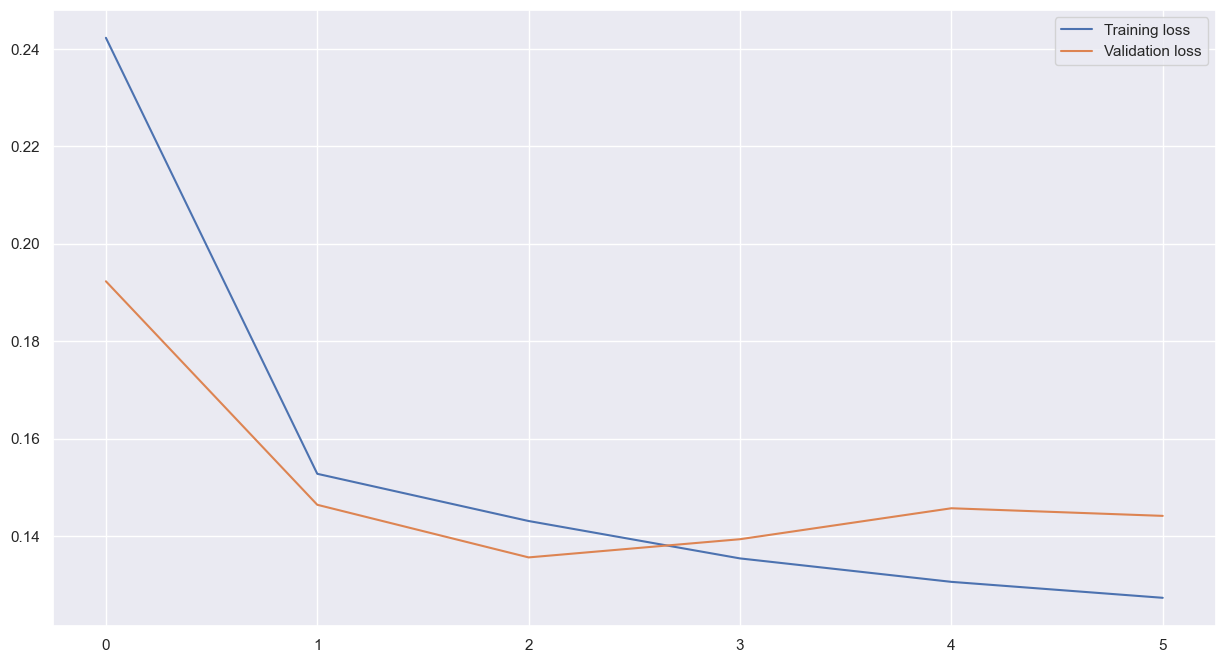

In [158]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [178]:
print(X_train.shape, X_train_pred.shape, train_mae_loss.shape)

(1035, 60, 1) (1035, 60, 1) (1035, 1)


Reconstruction error threshold: 0.20733001944173948


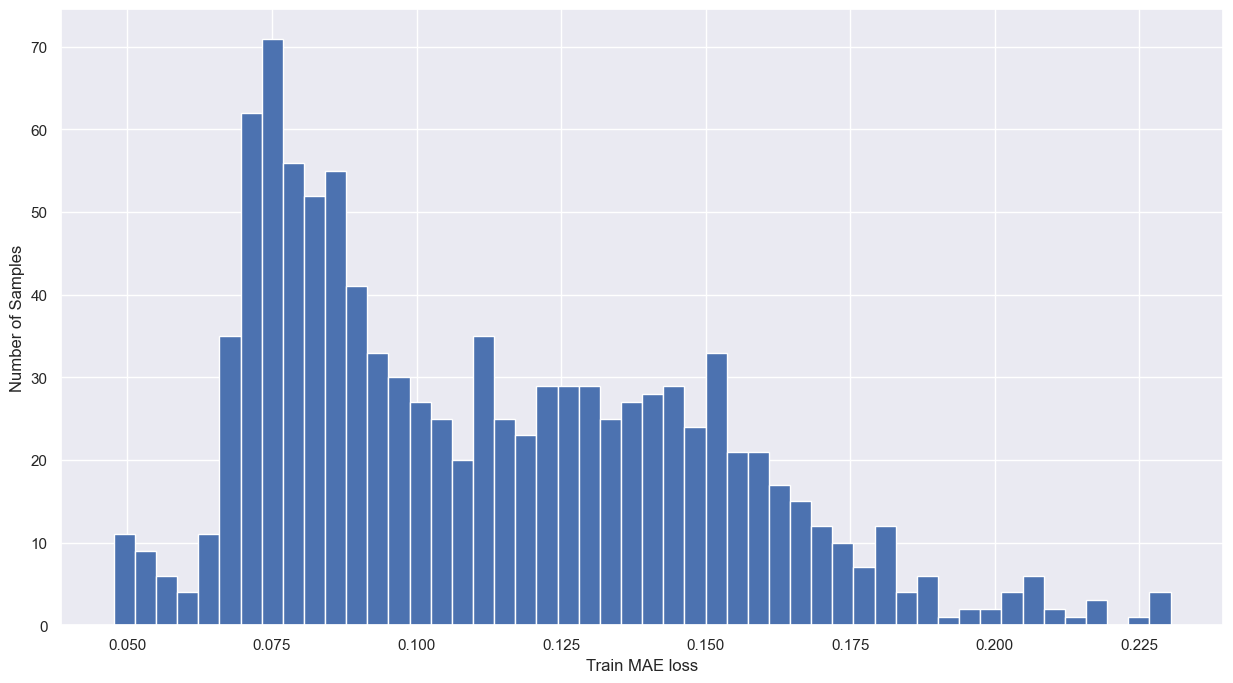

In [163]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)*0.9
print(f'Reconstruction error threshold: {threshold}')

<AxesSubplot:xlabel='starttime_ft', ylabel='prediction'>

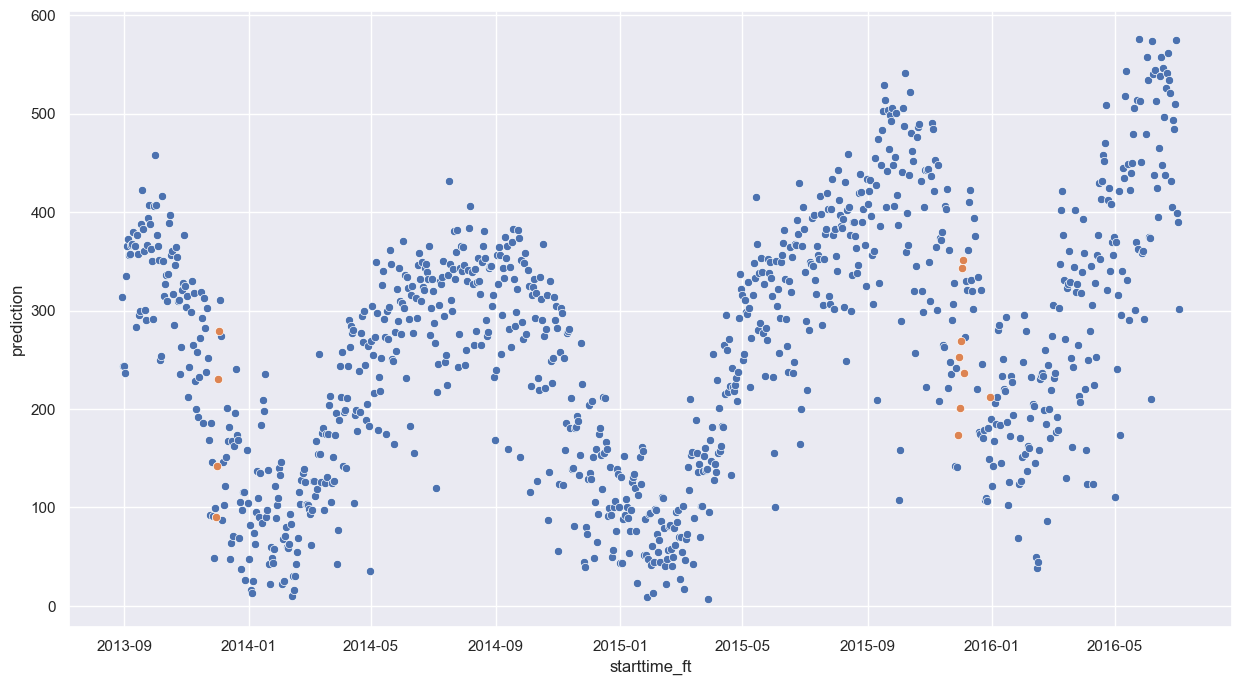

In [175]:
train_score_df = pd.DataFrame(train[TIME_STEPS:])
train_score_df['loss'] = train_mae_loss
train_score_df['threshold'] = threshold
train_score_df['anomaly'] = train_score_df['loss'] > train_score_df['threshold']
train_score_df['tripduration'] = train[TIME_STEPS:]['tripduration']
train_score_df['prediction'] = scaler.inverse_transform(train_score_df['tripduration'].values.reshape(-1,1))


anomalies = train_score_df.loc[train_score_df['anomaly'] == True]
sns.scatterplot(x='starttime_ft', y='prediction', data= train_score_df)
sns.scatterplot(x='starttime_ft', y='prediction', data= anomalies)

<AxesSubplot:xlabel='starttime_ft', ylabel='loss'>

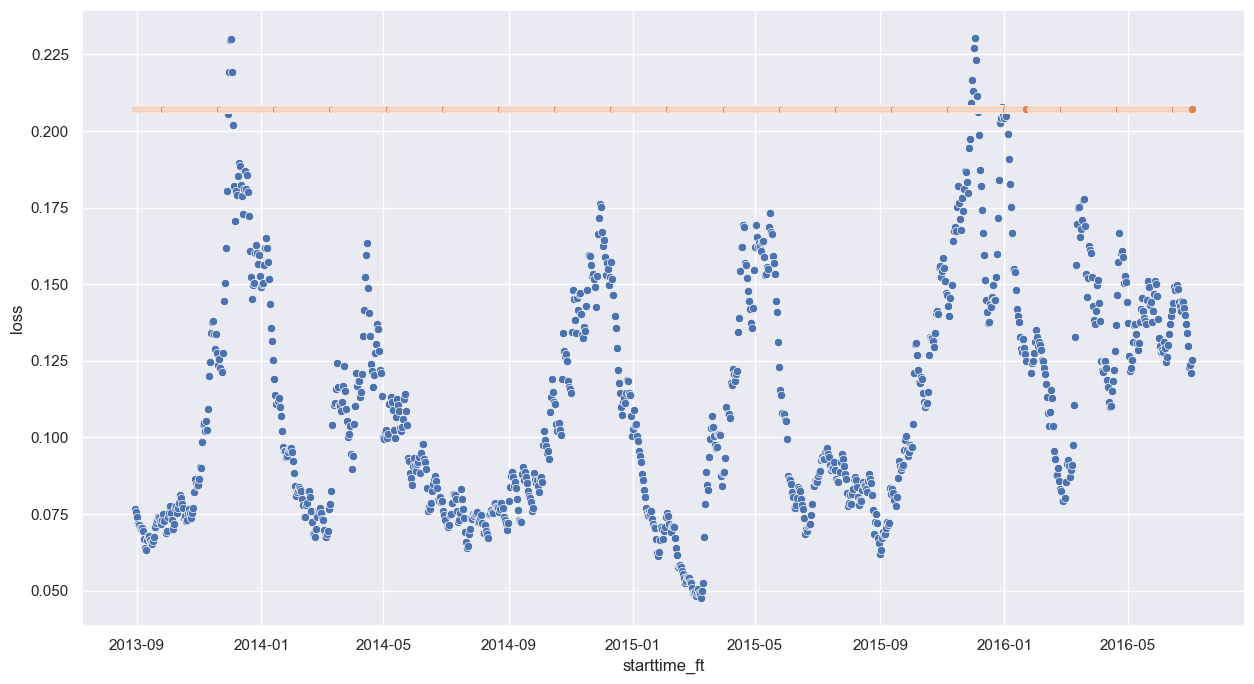

In [167]:
train_score_df = pd.DataFrame(train[TIME_STEPS:])
train_score_df['loss'] = train_mae_loss
train_score_df['threshold'] = threshold
train_score_df['anomaly'] = train_score_df['loss'] > train_score_df['threshold']
train_score_df['tripduration'] = train[TIME_STEPS:]['tripduration']


anomalies = train_score_df.loc[train_score_df['anomaly'] == True]
sns.scatterplot(x='starttime_ft', y='loss', data= train_score_df)
sns.scatterplot(x='starttime_ft', y='threshold', data= train_score_df)

In [177]:
pd.merge(anomalies, daily, on = 'starttime_ft')

,start_year_x,starttime_ft,start_month_x,start_dow_x,tripduration_x,loss,threshold,anomaly,prediction,start_year_y,start_month_y,start_dow_y,tripduration_y
0,2013,2013-11-30,11,5,0.139966,0.219108,0.20733,True,90.0,2013,11,5,90
1,2013,2013-12-01,12,6,0.227656,0.229684,0.20733,True,142.0,2013,12,6,142
2,2013,2013-12-02,12,0,0.376054,0.230137,0.20733,True,230.0,2013,12,0,230
3,2013,2013-12-03,12,1,0.458685,0.219117,0.20733,True,279.0,2013,12,1,279
4,2015,2015-11-29,11,6,0.281619,0.209025,0.20733,True,174.0,2015,11,6,174
5,2015,2015-11-30,11,0,0.414840,0.216663,0.20733,True,253.0,2015,11,0,253
6,2015,2015-12-01,12,1,0.327150,0.212944,0.20733,True,201.0,2015,12,1,201
7,2015,2015-12-02,12,2,0.441821,0.227077,0.20733,True,269.0,2015,12,2,269
8,2015,2015-12-03,12,3,0.566610,0.230367,0.20733,True,343.0,2015,12,3,343
9,2015,2015-12-04,12,4,0.580101,0.223208,0.20733,True,351.0,2015,12,4,351


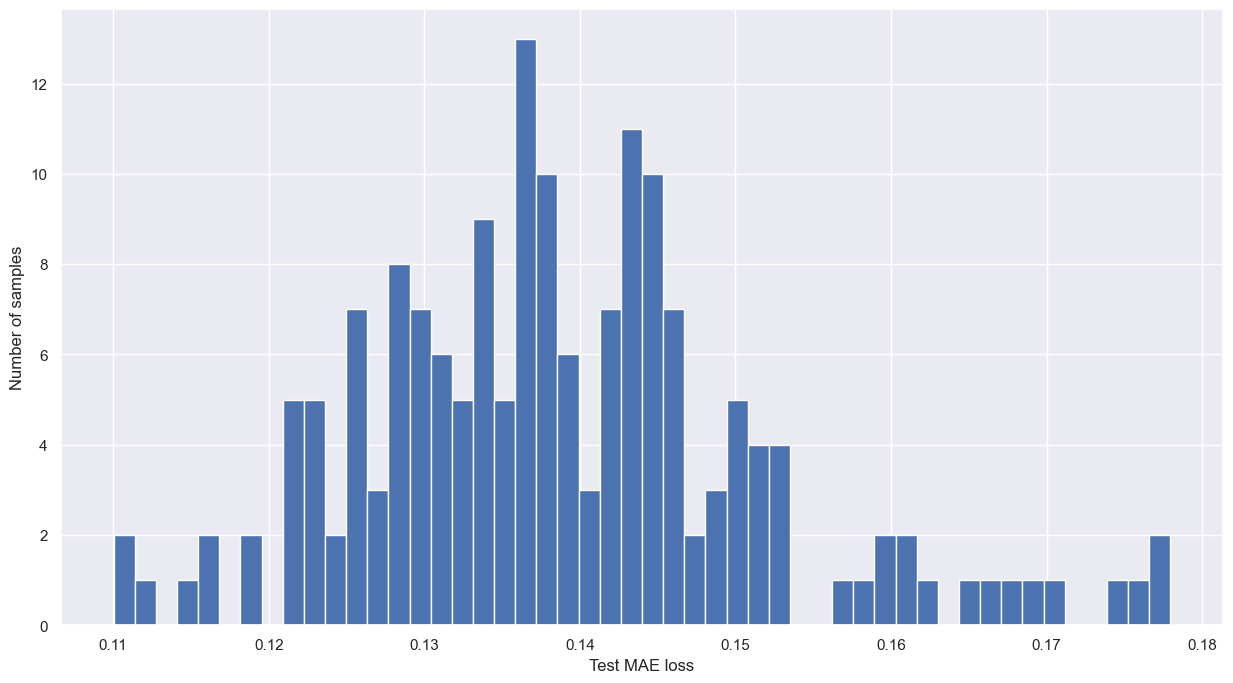

In [180]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

<AxesSubplot:xlabel='starttime_ft', ylabel='loss'>

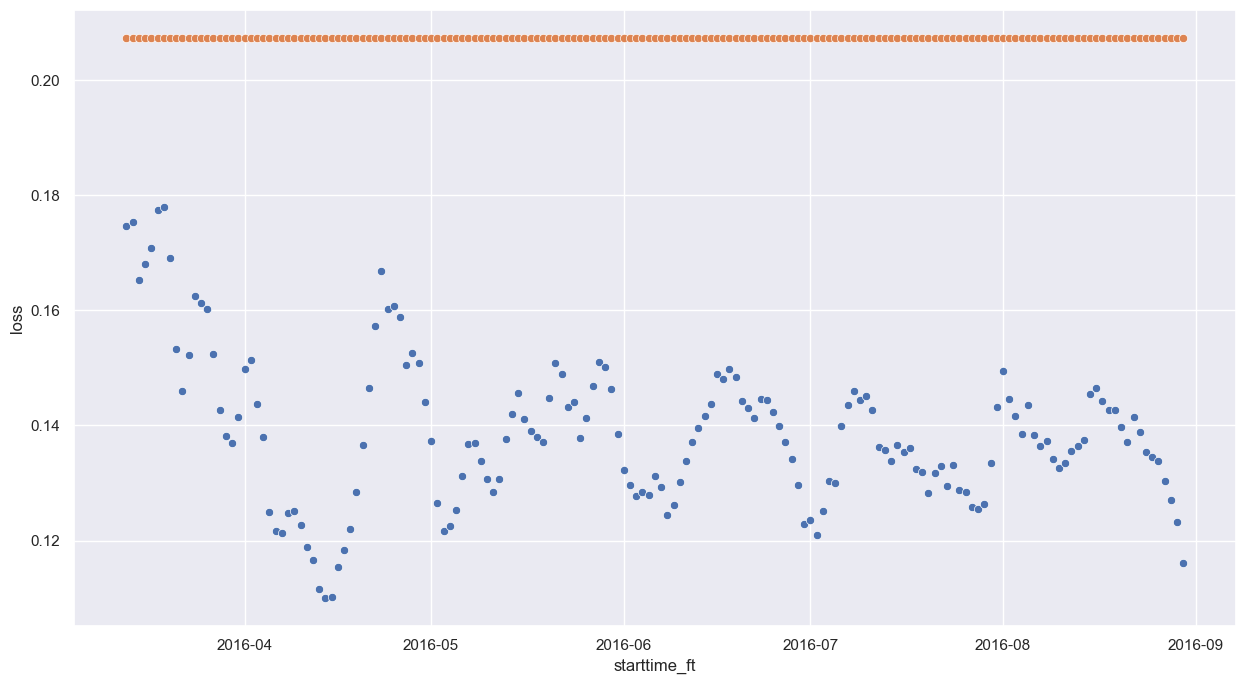

In [181]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['tripduration'] = test[TIME_STEPS:]['tripduration']


anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
sns.scatterplot(x='starttime_ft', y='loss', data= test_score_df)
sns.scatterplot(x='starttime_ft', y='threshold', data= test_score_df)

### Individual Trip Duration 

Text(0.5, 0, 'mean trip duration')

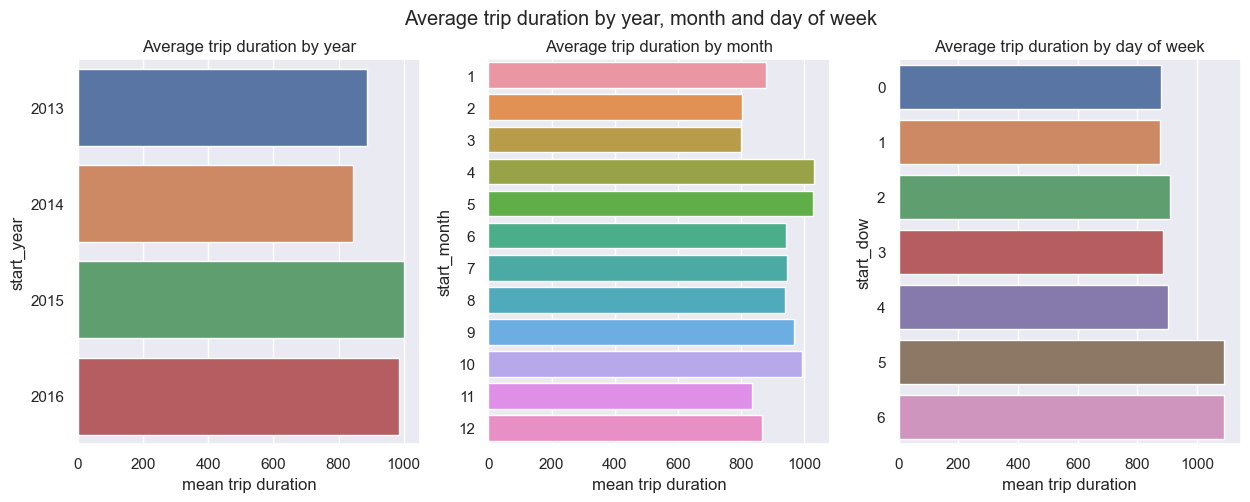

In [182]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
fig.suptitle('Average trip duration by year, month and day of week')

# by year
tmp = df_trip.groupby('start_year').agg({'tripduration':'mean'}).reset_index()
sns.barplot(ax=axes[0], x='tripduration', y='start_year',data=tmp,orient='h')
axes[0].set_title('Average trip duration by year')
axes[0].set_xlabel('mean trip duration')
# by month
tmp = df_trip.groupby('start_month').agg({'tripduration':'mean'}).reset_index()
sns.barplot(ax=axes[1], x='tripduration', y='start_month',data=tmp,orient='h')
axes[1].set_title('Average trip duration by month')
axes[1].set_xlabel('mean trip duration')
# by day of week
tmp = df_trip.groupby('start_dow').agg({'tripduration':'mean'}).reset_index()
sns.barplot(ax=axes[2], x='tripduration', y='start_dow',data=tmp,orient='h')
axes[2].set_title('Average trip duration by day of week')
axes[2].set_xlabel('mean trip duration')

We could find average trip duration is increasing year over year. And the trend is similar to daily trip, summer months tends to have longer duration comparing to winter months. 

However, weekday duration is lower than weekend which is opposite from the daily trips. Potential reasons could be weekday, users tend to use bike for work commute while weekend users more explore the bike which may take longer time


<AxesSubplot:ylabel='Frequency'>

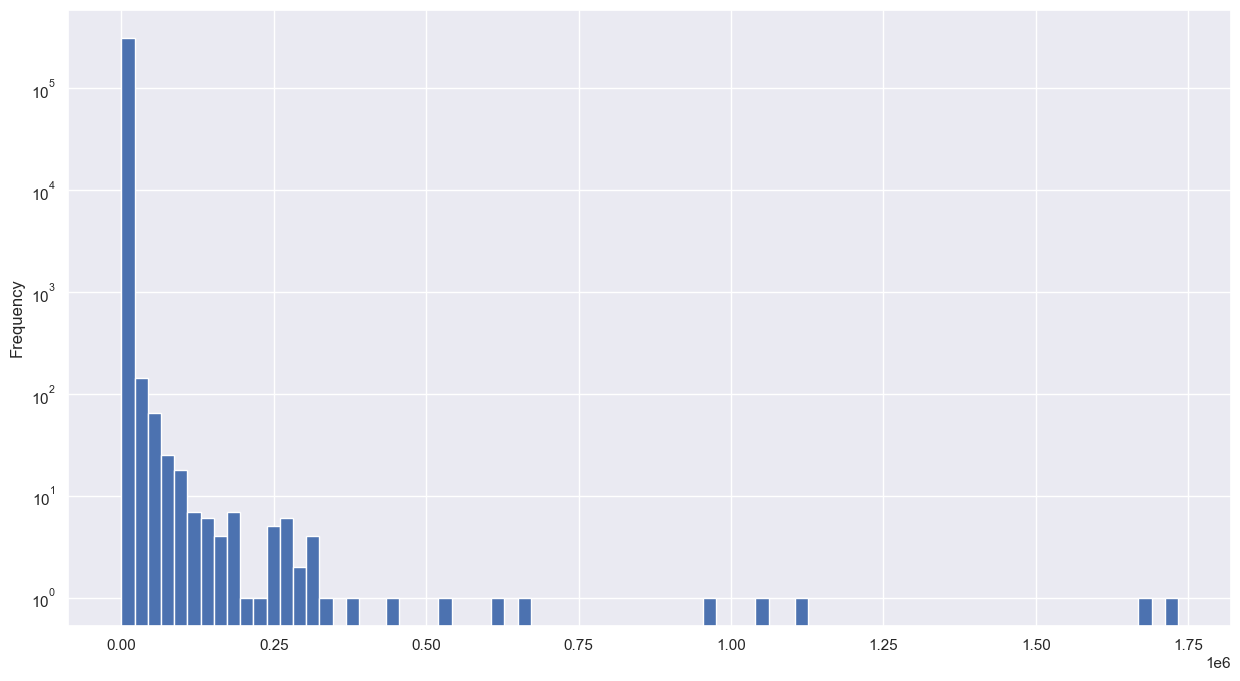

In [183]:
### check individual trip histogram
df_trip.tripduration.plot(kind='hist', logy=True,bins=80)

The distribution is pretty skewed, having a very long tail to the right. will use 3 standard deviation rule to mark the outlier, meantime we also need to pay attention to the very low value regarding the actual use case.

In [255]:
df_trip['duration_outlier'] = 0
df_trip['duration_outlier'][(np.abs(stats.zscore(df_trip['tripduration'])) > 3)] = 1

#### Univariete variable checking

1997.0


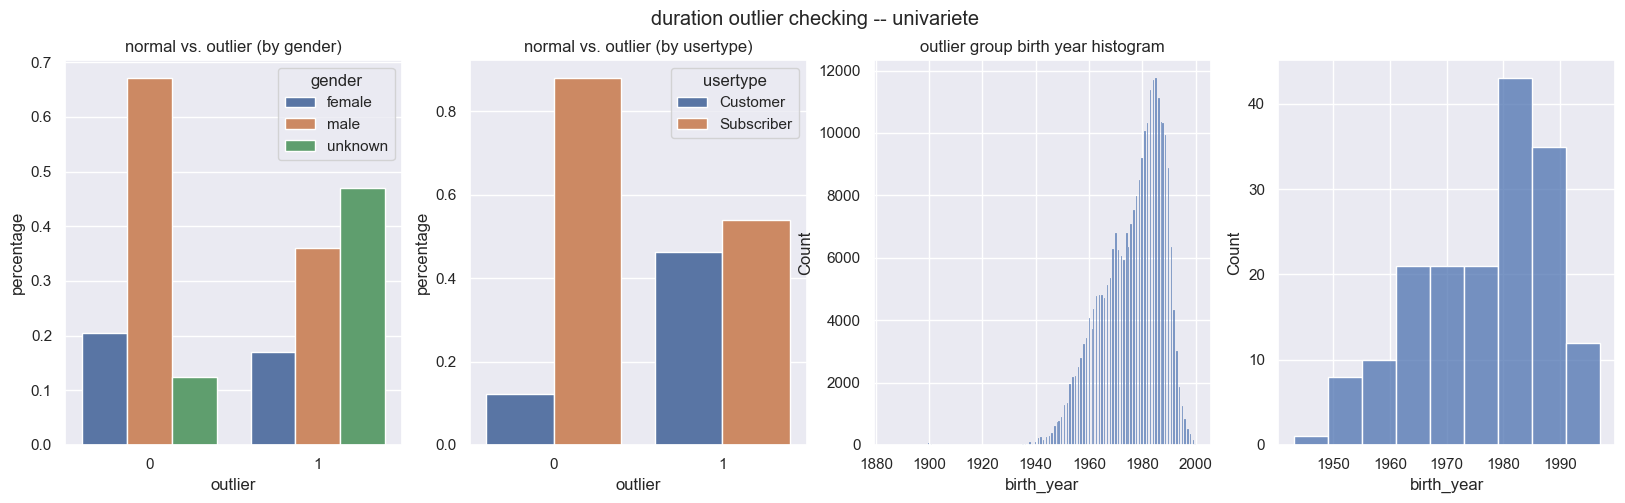

In [269]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=False)
fig.suptitle('duration outlier checking -- univariete')

# by year
tmp = df_trip.groupby(['duration_outlier','gender'])['tripduration'].count().reset_index()
tmp['percentage'] = tmp.groupby('duration_outlier')['tripduration'].transform(lambda x: x/x.sum())
sns.barplot(ax=axes[0], x='duration_outlier', y='percentage',hue = 'gender',data=tmp)
axes[0].set_title('normal vs. outlier (by gender)')
axes[0].set_xlabel('outlier')
# by month
tmp = df_trip.groupby(['duration_outlier','usertype'])['tripduration'].count().reset_index()
tmp['percentage'] = tmp.groupby('duration_outlier')['tripduration'].transform(lambda x: x/x.sum())
sns.barplot(ax=axes[1], x='duration_outlier', y='percentage',hue = 'usertype',data=tmp)
axes[1].set_title('normal vs. outlier (by usertype)')
axes[1].set_xlabel('outlier')
# by day of week
sns.histplot(ax=axes[2], x ='birth_year',data=df_trip[df_trip.duration_outlier == 0])
axes[2].set_title('normal group birth year histogram')
# axes[2].set_xlabel('mean trip duration')

sns.histplot(ax=axes[3], x ='birth_year',data=df_trip[df_trip.duration_outlier == 1])
axes[2].set_title('outlier group birth year histogram')
print(df_trip[df_trip.duration_outlier == 1].birth_year.max())






# # breaking down by gender
# tmp = df_trip.groupby(['duration_outlier','gender'])['tripduration'].count().reset_index()
# tmp['percentage'] = tmp.groupby('duration_outlier')['tripduration'].transform(lambda x: x/x.sum())
# sns.barplot( x='duration_outlier', y='percentage',hue = 'gender',data=tmp)



Takeaways:

* unknown users percentage is higher in outlier group comparing to normal group
* customer percentage is higher in outlier group comparing to normal group
* from birth year histogram, we could find normal group has more young user while outlier the most recent birth year is 1997.

* one potential assumption is that there are some usage difference between different group.

Text(0.5, 1.0, 'customer vs. subscriber average duration per trip (by day of week)')

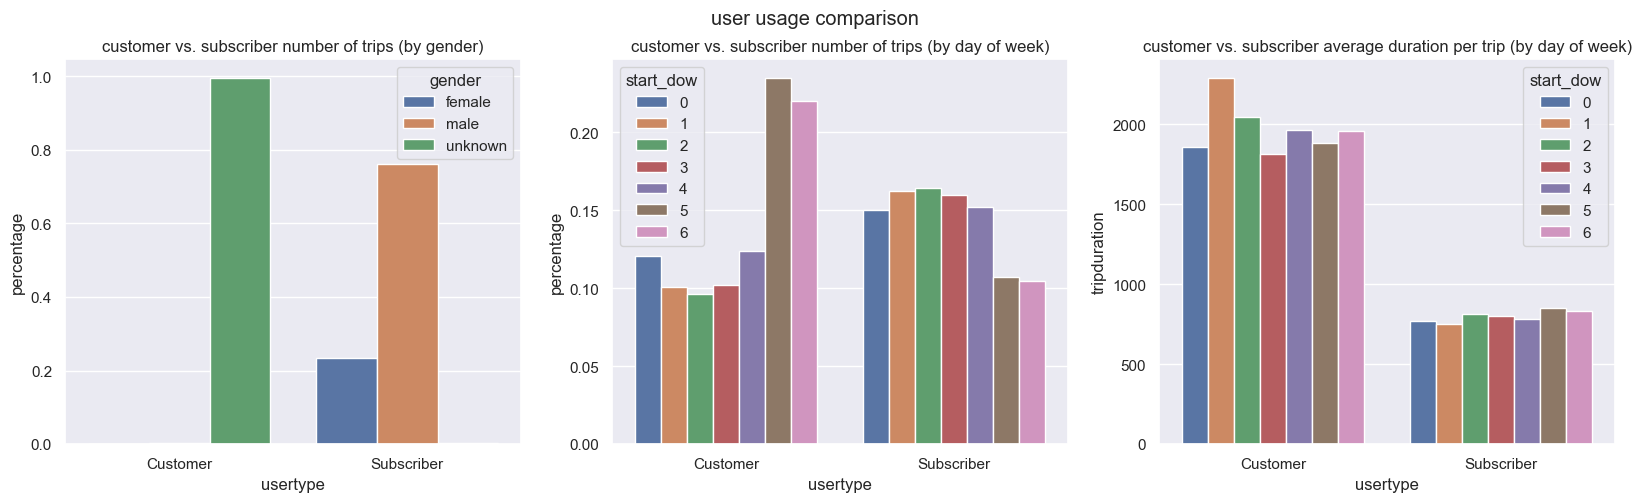

In [281]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
fig.suptitle('user usage comparison')

# customer vs. subscriber by gender
tmp = df_trip.groupby(['usertype','gender'])['tripduration'].count().reset_index()
tmp['percentage'] = tmp.groupby('usertype')['tripduration'].transform(lambda x: x/x.sum())
sns.barplot(ax=axes[0], x='usertype', y='percentage',hue = 'gender',data=tmp)
axes[0].set_title('customer vs. subscriber number of trips (by gender)')

# 
tmp = df_trip.groupby(['usertype','start_dow'])['tripduration'].count().reset_index()
tmp['percentage'] = tmp.groupby('usertype')['tripduration'].transform(lambda x: x/x.sum())
sns.barplot(ax=axes[1], x='usertype', y='percentage',hue = 'start_dow',data=tmp)
axes[1].set_title('customer vs. subscriber number of trips (by day of week)')

# 
tmp = df_trip.groupby(['usertype','start_dow'])['tripduration'].mean().reset_index()
sns.barplot(ax=axes[2], x='usertype', y='tripduration',hue = 'start_dow',data=tmp)
axes[2].set_title('customer vs. subscriber average duration per trip (by day of week)')
# axes[2].set_xlabel('mean trip duration')


we could find that most unknown without gender information is from customer group. And customer group tend to have more trips at weekend while subscriber have more trips on weekdays. In addition, customer have longer duration per trip comparing to subcriber.

The potential reason could be the different user type between customer and subscriber. Customers use bike more for exploring purpose. People may enjoy the riding during weekend and not on a regular cadence so maybe not leaving the registration information. While subscriber more use bike for commuting purpose. So they use more bike on the weekdays and the duration is more stable.


#### check short trip

In [311]:
print(df_trip.tripduration.min())

60


In [313]:
df_trip[df_trip.tripduration<65].sample(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_year,start_month,start_week,start_day,start_dow,start_doy,starttime_ft,holiday,duration_outlier,trip_start_end
169355,60,2013-09-15 21:05:00,2013-09-15 21:06:00,387,Centre St & Chambers St,40.712733,-74.004607,387,Centre St & Chambers St,40.712733,-74.004607,16848,Customer,NaN,unknown,NaN,2013,9,37,15,6,258,2013-09-15,0,0,Centre St & Chambers St-Centre St & Chambers St
209047,61,2014-08-23 09:46:00,2014-08-23 09:47:00,404,9 Ave & W 14 St,40.740583,-74.005509,404,9 Ave & W 14 St,40.740583,-74.005509,20263,Subscriber,1967.0,male,NaN,2014,8,34,23,5,235,2014-08-23,0,0,9 Ave & W 14 St-9 Ave & W 14 St
42221,62,2015-08-27 06:57:00,2015-08-27 06:58:00,435,W 21 St & 6 Ave,40.741740,-73.994156,435,W 21 St & 6 Ave,40.741740,-73.994156,18878,Subscriber,1987.0,male,NaN,2015,8,35,27,3,239,2015-08-27,0,0,W 21 St & 6 Ave-W 21 St & 6 Ave
135224,63,2013-10-18 23:49:00,2013-10-18 23:50:00,345,W 13 St & 6 Ave,40.736494,-73.997044,345,W 13 St & 6 Ave,40.736494,-73.997044,19514,Subscriber,1985.0,male,NaN,2013,10,42,18,4,291,2013-10-18,0,0,W 13 St & 6 Ave-W 13 St & 6 Ave
107836,64,2015-06-28 18:22:00,2015-06-28 18:23:00,422,W 59 St & 10 Ave,40.770513,-73.988038,422,W 59 St & 10 Ave,40.770513,-73.988038,16060,Subscriber,1978.0,female,NaN,2015,6,26,28,6,179,2015-06-28,0,0,W 59 St & 10 Ave-W 59 St & 10 Ave


In [314]:
tmp = df_trip[df_trip.tripduration<65]
tmp[tmp.start_station_id == tmp.end_station_id].shape[0]/tmp.shape[0]

0.88

we notice most of the small trip having the same start and end station(~88%). We need to check with business team if there are any potential reason behind it. For example, if user is not able to start the bike or the bike is broken, will that result in this short trip? 

In addition, the minimum of the trip duration is 60s. We need to verify with the business team to see if that is by default or if there are any other reason for it.

### Task 2: Usage Forecast

Here we will pick the daily per trip to build the forecast model

In [202]:
df_trip.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_year,start_month,start_week,start_day,start_dow,start_doy,starttime_ft,holiday
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN,2016,3,10,9,2,69,2016-03-09,0
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN,2015,7,28,9,3,190,2015-07-09,0
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN,2016,1,2,11,0,11,2016-01-11,0


In [284]:
daily = df_trip.groupby(['starttime_ft'
                         ,'start_year','start_month','start_dow','holiday']).agg({'tripduration':'count'}).reset_index()

# train test split
alldates = sorted(set(daily.starttime_ft.values))
daily = daily.sort_values(by='starttime_ft')
train, test = daily.loc[daily.starttime_ft.isin(alldates[:int(len(alldates)*0.9)])],daily.loc[~daily.starttime_ft.isin(alldates[:int(len(alldates)*0.9)])]
print(train.starttime_ft.min(),train.starttime_ft.max())
print(test.starttime_ft.min(),test.starttime_ft.max())
print(train.shape, test.shape)

# scale the daily trip
scaler = MinMaxScaler()
scaler = scaler.fit(daily[['tripduration']])

train['tripduration'] = scaler.transform(train[['tripduration']])
test['tripduration'] = scaler.transform(test[['tripduration']])

# Split the data into training and testing sets
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps),:].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['start_year','start_month','start_dow','holiday','tripduration']], train['tripduration'])
X_test, y_test = create_sequences(test[['start_year','start_month','start_dow','holiday','tripduration']], test['tripduration'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

2013-07-01 00:00:00 2016-05-06 00:00:00
2016-05-07 00:00:00 2016-08-30 00:00:00
(1037, 6) (116, 6)
Training shape: (1007, 30, 5)
Testing shape: (86, 30, 5)


In [285]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mae')
model.summary()

2023-04-03 22:50:50.324280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-03 22:50:50.345232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-03 22:50:50.347332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_70 (LSTM)              (None, 128)               68608     
                                                                 
 dropout_70 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_30 (RepeatVec  (None, 30, 128)          0         
 tor)                                                            
                                                                 
 lstm_71 (LSTM)              (None, 30, 64)            49408     
                                                                 
 dropout_71 (Dropout)        (None, 30, 64)            0         
                                                                 
 time_distributed_31 (TimeDi  (None, 30, 1)            65        
 stributed)                                          

In [286]:
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


Epoch 1/50


2023-04-03 22:51:02.932073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-03 22:51:02.941705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-03 22:51:02.946637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

45/46 [============================>.] - ETA: 0s - loss: 0.2965

2023-04-03 22:51:14.139202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-03 22:51:14.141029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-03 22:51:14.143000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

46/46 [==============================] - 13s 98ms/step - loss: 0.2979 - val_loss: 0.4328
Epoch 2/50
46/46 [==============================] - 2s 42ms/step - loss: 0.2558 - val_loss: 0.2003
Epoch 3/50
46/46 [==============================] - 2s 43ms/step - loss: 0.2179 - val_loss: 0.1657
Epoch 4/50
46/46 [==============================] - 2s 43ms/step - loss: 0.2127 - val_loss: 0.1564
Epoch 5/50
46/46 [==============================] - 2s 49ms/step - loss: 0.2057 - val_loss: 0.1537
Epoch 6/50
46/46 [==============================] - 2s 48ms/step - loss: 0.2034 - val_loss: 0.1529
Epoch 7/50
46/46 [==============================] - 2s 43ms/step - loss: 0.2008 - val_loss: 0.1525
Epoch 8/50
46/46 [==============================] - 2s 47ms/step - loss: 0.1976 - val_loss: 0.1523
Epoch 9/50
46/46 [==============================] - 2s 43ms/step - loss: 0.1972 - val_loss: 0.1521
Epoch 10/50
46/46 [==============================] - 2s 44ms/step - loss: 0.1956 - val_loss: 0.1521
Epoch 11/50
46/46 [

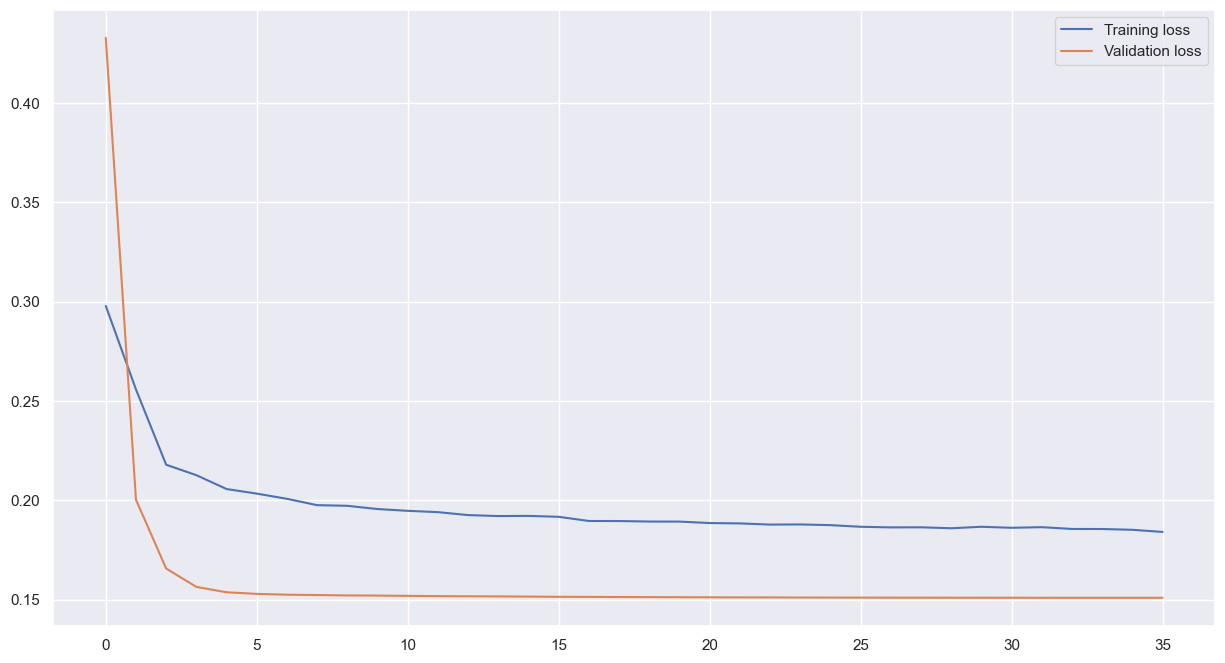

In [287]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

### Task 3: Station Insight


#### High traffics station and low traffic stations

<AxesSubplot:xlabel='tripduration', ylabel='start_station_name'>

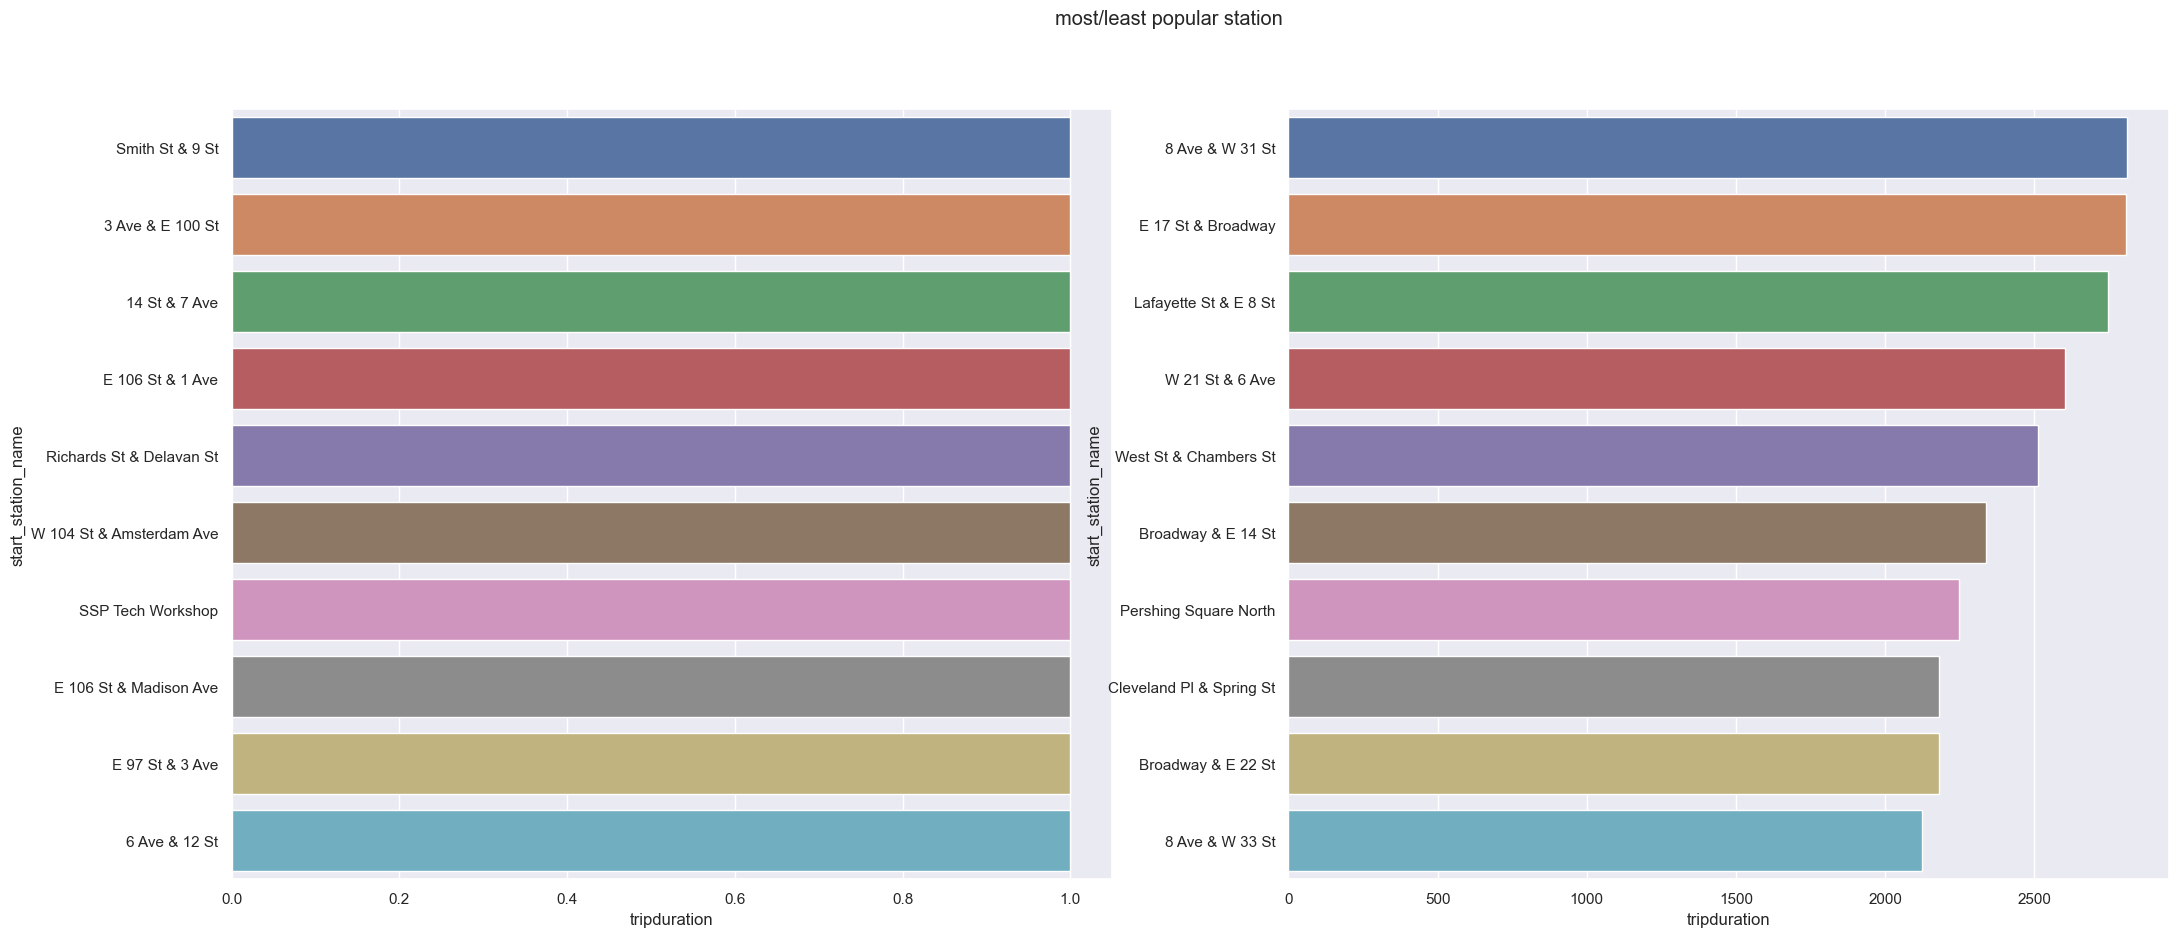

In [298]:
# High traffics station and low traffic stations
fig, axes = plt.subplots(1, 2, figsize=(25, 10), sharey=False)
fig.suptitle('most/least popular station')
tmp = df_trip.groupby('start_station_name')['tripduration'].count().reset_index().sort_values(by='tripduration')[:10]
sns.barplot(ax=axes[0], x='tripduration', y='start_station_name',data=tmp,orient='h')

tmp = df_trip.groupby('start_station_name')['tripduration'].count().reset_index().sort_values(by='tripduration',ascending=False)[:10]
sns.barplot(ax=axes[1], x='tripduration', y='start_station_name',data=tmp,orient='h')

#### most popular trip

Text(0.5, 1.0, 'most popular trip')

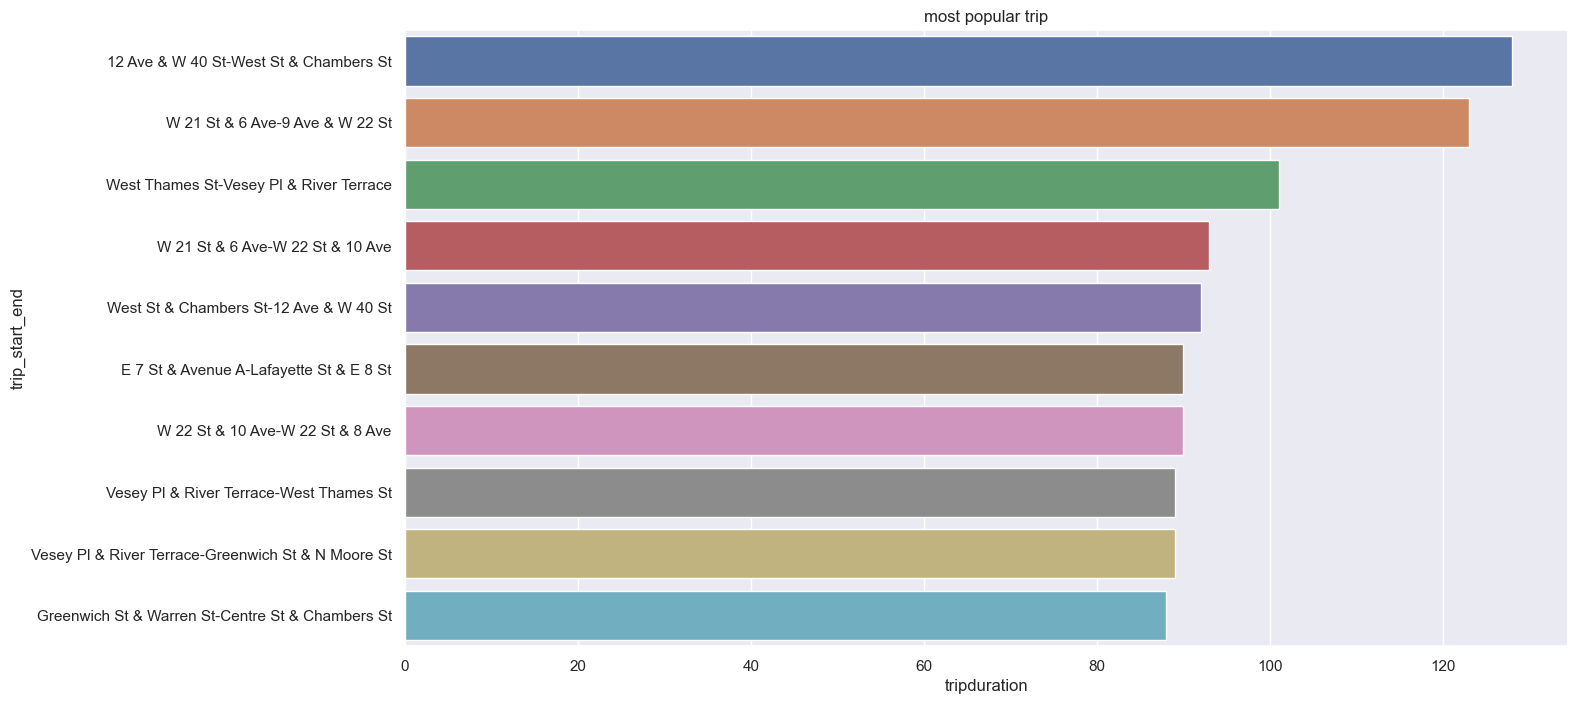

In [315]:
df_trip['trip_start_end'] = df_trip['start_station_name'] + '-'+df_trip['end_station_name']
tmp = df_trip[df_trip.start_station_id != df_trip.end_station_id].groupby('trip_start_end')['tripduration'].count().reset_index().sort_values(by='tripduration',ascending=False)[:10]
sns.barplot(x='tripduration', y='trip_start_end',data=tmp,orient='h')
plt.title("most popular trip")

Text(0.5, 1.0, 'popular trip other time')

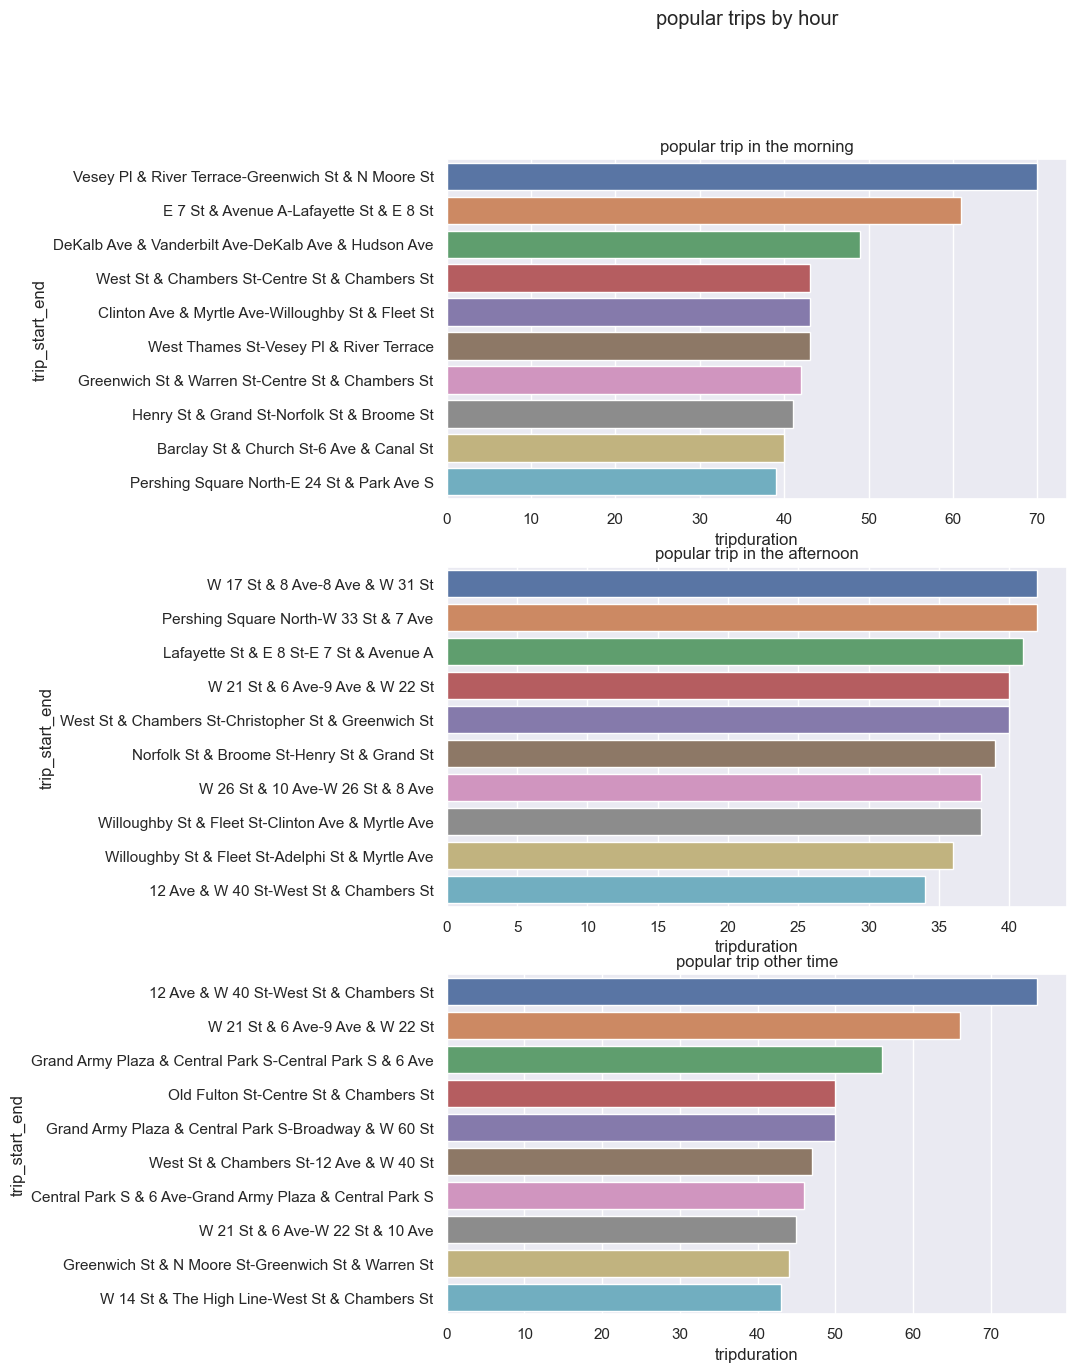

In [333]:
df_trip['start_hour'] = df_trip['starttime'].dt.hour
morning = [6,7,8,9,10]
afternoon = [17,18,19,20]
fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharey=False)
fig.suptitle('popular trips by hour')

# customer vs. subscriber by gender
tmp = df_trip[(df_trip.start_station_id != df_trip.end_station_id)& df_trip.start_hour.isin(morning)].groupby('trip_start_end')['tripduration'].count().reset_index().sort_values(by='tripduration',ascending=False)[:10]
sns.barplot(ax= axes[0],x='tripduration', y='trip_start_end',data=tmp,orient='h')
axes[0].set_title('popular trip in the morning')

# 
tmp = df_trip[(df_trip.start_station_id != df_trip.end_station_id)& df_trip.start_hour.isin(afternoon)].groupby('trip_start_end')['tripduration'].count().reset_index().sort_values(by='tripduration',ascending=False)[:10]
sns.barplot(ax= axes[1],x='tripduration', y='trip_start_end',data=tmp,orient='h')
axes[1].set_title('popular trip in the afternoon')

# 
tmp = df_trip[(df_trip.start_station_id != df_trip.end_station_id)& ~df_trip.start_hour.isin(morning) & ~df_trip.start_hour.isin(afternoon)].groupby('trip_start_end')['tripduration'].count().reset_index().sort_values(by='tripduration',ascending=False)[:10]
sns.barplot(ax= axes[2],x='tripduration', y='trip_start_end',data=tmp,orient='h')
axes[2].set_title('popular trip other time')
# axes[2].set_xlabel('mean trip duration')


we could find the morning and afternoon showing the opposite trip trend. People ususally enter the city in the morning before work and after work shows the opposite direction which indicates people going home after work.

#### Most popular bike

Text(0.5, 1.0, 'most popular bike')

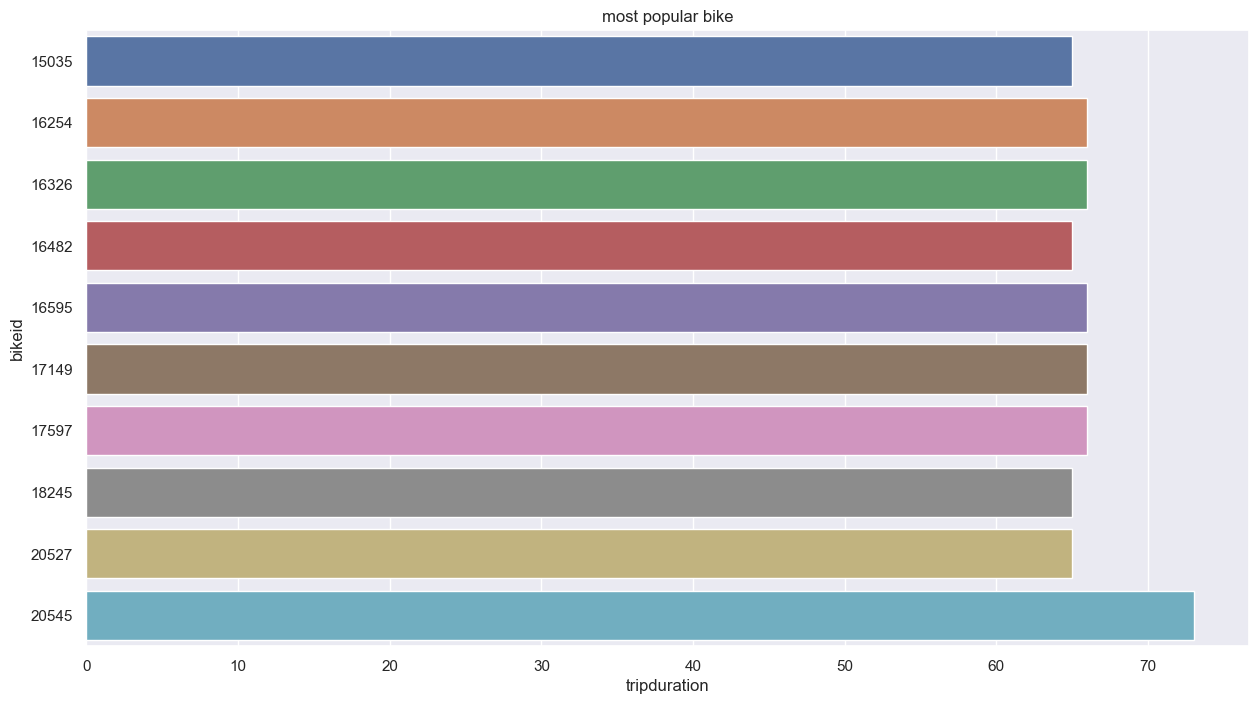

In [336]:
tmp = df_trip[df_trip.start_station_id != df_trip.end_station_id].groupby('bikeid')['tripduration'].count().reset_index().sort_values(by='tripduration',ascending=False)[:10]
sns.barplot(x='tripduration', y='bikeid',data=tmp,orient='h')
plt.title("most popular bike")

In [335]:
df_trip.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,start_year,start_month,start_week,start_day,start_dow,start_doy,starttime_ft,holiday,duration_outlier,trip_start_end,start_hour
0,2319,2016-03-09 13:08:00,2016-03-09 13:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN,2016,3,10,9,2,69,2016-03-09,0,0,W 52 St & 5 Ave-West Thames St,13
1,313,2015-07-09 15:42:00,2015-07-09 15:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN,2015,7,28,9,3,190,2015-07-09,0,0,W 52 St & 5 Ave-W 45 St & 6 Ave,15
2,906,2016-01-11 18:32:00,2016-01-11 18:47:00,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN,2016,1,2,11,0,11,2016-01-11,0,0,W 52 St & 5 Ave-W 78 St & Broadway,18
